In [1]:

import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", category=UserWarning, module='PIL.Image')

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras

# Data preprocessing

# image preprocessing

# What does rescale=1./255 do?
## Rescaling Pixel Values:
### Digital images are typically represented as arrays of pixel values. For most image formats, these pixel values range from 0 to 255 for each color channel (red, green, and blue in RGB images).
### By setting rescale=1./255, you are dividing each pixel value by 255, which normalizes the pixel values to the range [0, 1]. This is important because neural networks generally perform better and converge faster when the input values are scaled to a small range, typically [0, 1] or [-1, 1].

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators(train_dir, val_dir, target_size=(150, 150), batch_size=32, class_mode='categorical'):
    """
    Creates ImageDataGenerators for training and validation datasets.

    Parameters:
    - train_dir (str): Path to the training data directory.
    - val_dir (str): Path to the validation data directory.
    - target_size (tuple): Size to which all images found will be resized.
    - batch_size (int): Number of images to be yielded from the generator per batch.
    - class_mode (str): Type of label arrays to return. Can be 'categorical', 'binary', 'sparse', 'input', or None.

    Returns:
    - train_generator: A DirectoryIterator for training data.
    - val_generator: A DirectoryIterator for validation data.
    """
    # Create an instance of ImageDataGenerator with rescaling
    datagen = ImageDataGenerator(rescale=1./255)

    # Create training data generator
    train_generator = datagen.flow_from_directory(
        train_dir,                      # Path to the training data
        target_size=target_size,        # Resize all images to specified target size
        batch_size=batch_size,          # Number of images to return in each batch
        class_mode=class_mode,          # Type of label arrays to return
        shuffle=True,                   # Shuffle the data
        interpolation='bilinear'        # Method to use when resizing images
    )

    # Create validation data generator
    val_generator = datagen.flow_from_directory(
        val_dir,                        # Path to the validation data
        target_size=target_size,        # Resize all images to specified target size
        batch_size=batch_size,          # Number of images to return in each batch
        class_mode=class_mode,          # Type of label arrays to return
        shuffle=True,                   # Shuffle the data
        interpolation='bilinear'        # Method to use when resizing images
    )
    
    return train_generator, val_generator

train_generator, val_generator = create_data_generators(
    train_dir="C:/Users/USER/Desktop/My Drive/Project/Fruits Recognition/train",
    val_dir="C:/Users/USER/Desktop/My Drive/Project/Fruits Recognition/validation",
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.


# Why (150, 150) Was Used:
## In many tutorials and standard practices, (150, 150) is chosen as a balance between capturing enough detail and not overwhelming the model with too much data. It's a size that works well with a variety of CNN architectures without requiring extensive computational resources.

# Building Model

# Building convolution Layer

# Explanation
## filters=64: This specifies the number of filters in the convolutional layer.
## kernel_size=(3, 3): This specifies the size of the convolution window (3x3).
## activation='relu': This applies the ReLU activation function.
## input_shape=(150, 150, 3): This specifies the shape of the input data, where (150, 150, 3) means images of size 150x150 with 3 color channels (RGB).

# Why use relu
## 1. Introduction of Non-Linearity:
## Neural networks need non-linear activation functions to learn and model complex patterns in the data. Without non-linearity, a network with multiple layers would behave like a single-layer model, limiting its learning capacity.
## ReLU introduces non-linearity by transforming any negative input value to zero, while keeping positive values unchanged:
# ReLU(𝑥)=max(0,𝑥)
# ReLU(x)=max(0,x)
## 2. Simplicity and Computational Efficiency:
## ReLU is computationally simpler and faster compared to other activation functions like sigmoid or tanh, as it only involves a simple thresholding at zero.
## This simplicity allows for quicker training times, which is particularly important for deep networks.
### 3. Mitigating the Vanishing Gradient Problem:
## In deep networks, gradients can become very small during backpropagation, especially when using activation functions like sigmoid or tanh. This can slow down learning significantly.
## ReLU helps mitigate the vanishing gradient problem because it maintains a gradient of 1 for positive inputs, ensuring that gradients don't vanish as quickly in deep networks.
## 4. Sparse Activation:
## ReLU promotes sparsity in the network by zeroing out negative values. This means that during training, only a portion of the neurons in a given layer are activated (i.e., contribute to the output), which can improve the efficiency and robustness of the model.
# When Not to Use ReLU:
## Dying ReLU Problem: If too many neurons output zero during training, it can lead to the "dying ReLU" problem, where neurons stop learning altogether. To mitigate this, variants like Leaky ReLU or Parametric ReLU (PReLU) can be used.
# In summary, ReLU is widely used because it strikes a good balance between simplicity, efficiency, and effectiveness in training deep networks, making it the go-to activation function in many deep learning models.


# Building Pooling Layers

# Explanation:
## MaxPooling2D: This layer performs max pooling operation on 2D spatial data (like images), reducing the spatial dimensions (height and width) of the input data while retaining the most important information.
## pool_size: Defines the size of the pooling window. In this case, (2, 2) means that a 2x2 window will be used to perform the pooling operation.
## strides: Specifies the stride of the pooling operation. In this case, 2 means that the pooling window will move 2 steps horizontally and 2 steps vertically across the input data.

# The MaxPooling layer is typically used after convolutional layers to reduce the dimensionality of the feature maps, which helps in reducing computational complexity and controlling overfitting.

# Explanation:
## Dropout: This layer is used to prevent overfitting in neural networks by randomly setting a fraction of the input units to 0 during training. This forces the model to not rely too heavily on any individual neuron and improves generalization.
## 0.5: The fraction of input units to drop. In this case, 0.5 means that during each training step, 50% of the input units to the Dropout layer will be set to 0

# The Flatten layer in a Convolutional Neural Network (CNN) is used to convert the 2D matrix output of the convolutional and pooling layers into a 1D vector. This conversion is necessary because the next layers in the network, typically fully connected (Dense) layers, require a 1D input.

# Why Flatten is Important:
## Transition from Convolutional to Dense Layers:

## Convolutional and pooling layers operate on 2D data (e.g., images), preserving the spatial structure.
## Dense layers, which are fully connected, expect a 1D input, where each node is connected to all nodes in the previous layer.
## Flattening bridges this gap by converting the 2D output (a feature map) into a 1D vector that the Dense layers can process.
# Preparing Features for Classification:

## After the convolutional layers have extracted features from the input data, Flattening prepares these features to be passed through fully connected layers, where they can be combined and used to classify the input.

# Example:

## Suppose the last pooling layer produces an output with dimensions 7×7×64
### 7×7×64 (height, width, number of filters).
## The Flatten layer will convert this to a 1D vector of size 7×7×64 = 3136
# 7×7×64=3136.
## This 1D vector is then fed into the Dense layers for classification.
# Without Flatten:
## If you skip the Flatten layer, the Dense layers won't be able to process the multi-dimensional data directly, leading to errors or incorrect model architecture.

# Order of Operations:
## The usual flow in a CNN is:
## Convolution and Pooling Layers: Extract features and reduce dimensionality.
### Flatten: Prepare the data for Dense layers by converting it to 1D.
### Dropout: Regularize the network by randomly dropping some features.
### Dense Layers: Perform the final classification or regression tasks.
## Example Workflow:
### Convolutional Layers: Extract features from the input image.
### Pooling Layers: Reduce the dimensionality while preserving important features.
### Flatten: Convert the 2D feature maps into a 1D vector.
### Dropout: Regularize the model by dropping some features in the 1D vector.
### Dense Layers: Use the processed features to perform classification or regression.
### If you placed Dropout before Flatten, the Dropout would be applied to the multi-dimensional data, which isn't typical and could disrupt the spatial structure that the convolutional layers have learned. Flatten ensures that the data is in the correct format for Dropout to effectively randomize the features before feeding them into the Dense layers.

# we have 36 classes,so we expect 36 output (this is a multi-class classification)


# Why use the softmax activation function

## The `softmax` activation function is commonly used in the output layer of a neural network when performing multi-class classification. Here's why it's appropriate to use `softmax` in your output layer:

### 1. **Multi-Class Classification**:
   - **Softmax Functionality**: The `softmax` function converts the raw output scores (logits) of the network into probabilities. It does this by applying the exponential function to each output and then normalizing these values so that they sum to 100%. Each neuron in the output layer corresponds to a class, and the softmax output gives the probability that the input belongs to each class.
   - **Usage in Output Layer**: When you have multiple classes to predict (e.g., 36 classes in your case), you use `softmax` to get a probability distribution across all classes. The class with the highest probability is typically chosen as the model's prediction.

### 2. **Why 36 Units?**
   - **Units = Number of Classes**: The number of units in the output layer should match the number of classes in your classification task. If you have 36 possible classes, you need 36 units in the output layer, one for each class.

### 3. **Example Context**:
   - **Output Layer for Classification**: For example, if you're building a model to classify images into 36 different categories, the final dense layer would look something like this:

     ```python
     model.add(layers.Dense(units=36, activation='softmax'))
     ```

   - **Prediction**: After the model processes an input, the softmax layer outputs 36 probabilities, one for each class. The sum of these probabilities will be 1, and the model's prediction is the class with the highest probability.

### 4. **Softmax vs. Other Activation Functions**:
   - **Softmax** is specifically designed for multi-class classification. If you were dealing with binary classification, you would typically use a single unit with a `sigmoid` activation function instead.
   - **ReLU, tanh, sigmoid**: These are activation functions used in hidden layers to introduce non-linearity, but they don't serve the purpose of converting logits to probabilities over multiple classes.

### In Summary:
You use `softmax` in the output layer of a neural network when you want to perform multi-class classification, as it converts logits into a probability distribution across all possible classes, allowing you to interpret the model's predictions in terms of probabilities for each class.

In [7]:
from tensorflow.keras import regularizers
from tensorflow.keras import layers,models

# Define the model with regularization
model = models.Sequential()

# First block
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

# Second block
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

# Third block
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

# Fourth block
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

# Flatten and dense layers
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=36, activation='softmax'))  # Output layer


In [8]:
from tensorflow.keras.metrics import Precision

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), 'mae'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 71, 71, 64)        2

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define learning rate reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [11]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
98/98 [==============================] - 235s 2s/step - loss: 5.3492 - accuracy: 0.1737 - precision: 0.3429 - mae: 0.0496 - val_loss: 7.7598 - val_accuracy: 0.0285 - val_precision: 0.3333 - val_mae: 0.0536
Epoch 2/50
98/98 [==============================] - 289s 3s/step - loss: 4.6987 - accuracy: 0.2754 - precision: 0.4517 - mae: 0.0455 - val_loss: 9.8172 - val_accuracy: 0.0427 - val_precision: 0.0449 - val_mae: 0.0533
Epoch 3/50
98/98 [==============================] - 367s 4s/step - loss: 4.3797 - accuracy: 0.3490 - precision: 0.5527 - mae: 0.0430 - val_loss: 7.6793 - val_accuracy: 0.0513 - val_precision: 0.0688 - val_mae: 0.0525
Epoch 4/50
98/98 [==============================] - 321s 3s/step - loss: 4.1086 - accuracy: 0.3913 - precision: 0.5984 - mae: 0.0407 - val_loss: 5.1632 - val_accuracy: 0.2108 - val_precision: 0.2876 - val_mae: 0.0463
Epoch 5/50
98/98 [==============================] - 358s 4s/step - loss: 3.9813 - accuracy: 0.3968 - precision: 0.5940 - mae: 0.0401

# save the model

In [13]:
history.history

{'loss': [5.349238395690918,
  4.698712348937988,
  4.379699230194092,
  4.10860013961792,
  3.9812729358673096,
  3.8434581756591797,
  3.6666131019592285,
  3.4543869495391846,
  3.3908262252807617,
  3.283534288406372,
  3.166365146636963,
  2.821237325668335,
  2.623629331588745,
  2.4968669414520264,
  2.391596555709839,
  2.288573741912842,
  2.196742057800293,
  2.103269577026367,
  2.0597546100616455,
  1.9601457118988037,
  1.884419560432434,
  1.8383641242980957,
  1.772544503211975,
  1.7169421911239624,
  1.6750009059906006,
  1.625784993171692,
  1.5832797288894653,
  1.5501172542572021,
  1.4921218156814575,
  1.4749730825424194,
  1.433136224746704,
  1.4025707244873047,
  1.3644907474517822,
  1.3490235805511475,
  1.3466249704360962,
  1.3118058443069458,
  1.2616759538650513,
  1.2508527040481567,
  1.2201076745986938,
  1.2288486957550049,
  1.2003498077392578,
  1.1819792985916138,
  1.1585839986801147,
  1.1698119640350342,
  1.1734440326690674,
  1.106540679931640

In [50]:
model.save('my_model.h5')

In [51]:
import json

# Convert the training history to a serializable format
def convert_to_serializable(history):
    for key in history:
        if isinstance(history[key], list):
            history[key] = [float(value) for value in history[key]]
    return history

# Assuming `training_history` is the history object returned by `model.fit`
serializable_history = convert_to_serializable(history.history)

# Save the serializable history to a JSON file
with open('trained_hist.json', 'w') as f:
    json.dump(serializable_history, f)


In [52]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'mae', 'val_loss', 'val_accuracy', 'val_precision', 'val_mae', 'lr'])


## calculting accuracy achieved on val_accuracy

In [53]:
# Accessing 'val_accuracy' from the training history dictionary
val_accuracy = history.history['val_accuracy']


In [54]:
print('Validtion set Accuracy: {:.2f} %'.format (val_accuracy[-1]*100))

Validtion set Accuracy: 96.87 %


# Training and Validation Accuracy Visualization

In [55]:
epoch = range(1, len(history.history['accuracy']) + 1)

Text(0.5, 1.0, 'Visualization of Training Accuracy Result')

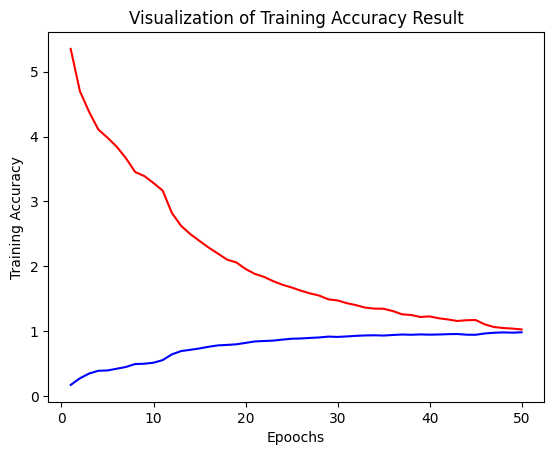

In [56]:
# Access 'val_accuracy' from the history dictionary

plt.plot(epoch,history.history['accuracy'], color = 'blue')
plt.plot(epoch,history.history['loss'], color = 'red')
plt.xlabel("Epoochs")
plt.ylabel("Training Accuracy")
plt.title("Visualization of Training Accuracy Result")

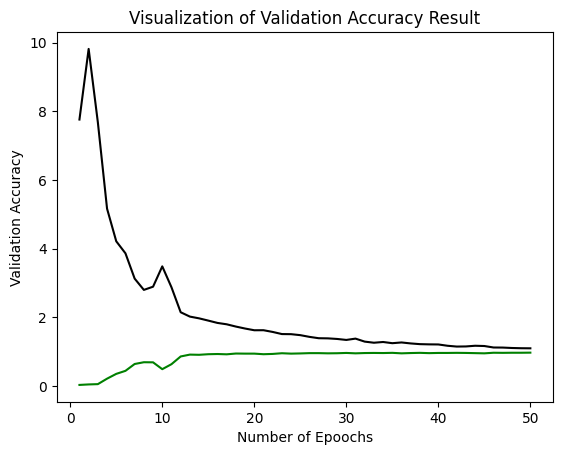

In [57]:

plt.plot(epoch,history.history['val_accuracy'], color = 'green')
plt.plot(epoch,history.history['val_loss'], color = 'black')
plt.xlabel("Number of Epoochs")
plt.ylabel("Validation Accuracy")
plt.title("Visualization of Validation Accuracy Result")
plt.show()

# Model testing

In [58]:
model = models.load_model('trained_model.h5')

# performing prediction on single image

Found 359 images belonging to 36 classes.


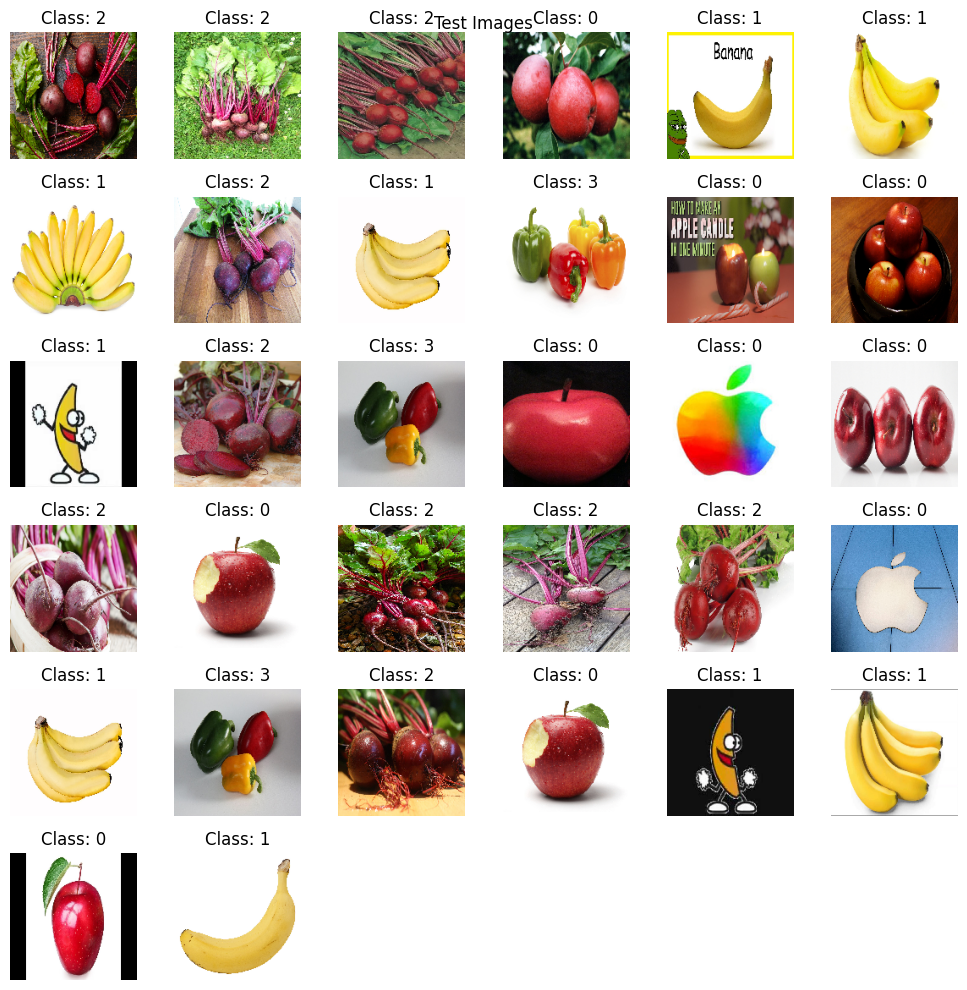

In [59]:
# Define the path to the directory
path = r"C:\Users\USER\Desktop\My Drive\Project\Fruits Recognition\New folder"

# Initialize ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the generator
test_generator = test_datagen.flow_from_directory(
    path,
    target_size=(150, 150),
    batch_size=32,  # Batch size of 32
    class_mode='categorical',
    shuffle=False
)

# Get a batch of images and labels
images, labels = next(test_generator)

# Number of images to display
num_images = 36

num_images = min(num_images, images.shape[0])

# Get random indices for sampling
indices = np.random.choice(images.shape[0], num_images, replace=False)

# Plot images
plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices):
    plt.subplot(6, 6, i + 1)
    plt.imshow(images[idx])
    plt.title(f"Class: {np.argmax(labels[idx])}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Test Images")
plt.show()


In [60]:
print("Images shape:", images.shape)


Images shape: (32, 150, 150, 3)


In [61]:
print(type(images))  # <class 'numpy.ndarray'>
print(images.shape)  # E.g., (32, 150, 150, 3) for a batch of 32 images, 150x150 pixels, 3 channels

print(type(labels))  # <class 'numpy.ndarray'>
print(labels.shape) 

<class 'numpy.ndarray'>
(32, 150, 150, 3)
<class 'numpy.ndarray'>
(32, 36)


In [62]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess a single image
img_path = r"C:\Users\USER\Desktop\My Drive\Project\Fruits Recognition\New folder\bell pepper\Image_6.jpg"
img = image.load_img(img_path, target_size=(150, 150))  # Match the size used during training
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create a batch dimension
img_array /= 255.0  # Normalize if needed (match training preprocessing)



In [63]:

# Make a prediction
prediction = model.predict(img_array)


In [64]:
print(prediction) 

[[7.6982069e-06 2.1260489e-06 1.5405529e-05 9.8984724e-01 1.8646352e-06
  7.4437931e-03 6.1870287e-06 1.7433283e-06 3.1161378e-04 4.0631785e-06
  1.9347062e-06 1.2006874e-06 4.5940064e-07 3.7462466e-06 4.9008345e-06
  6.0799503e-05 1.0392530e-06 1.1297576e-04 2.5517379e-06 5.9222311e-05
  5.5759717e-09 2.0565676e-04 6.5500097e-04 1.7025952e-04 4.1384960e-06
  1.5269849e-05 5.8690479e-05 9.6376915e-08 3.4859884e-05 1.2471530e-07
  3.0228807e-06 5.5800128e-06 1.0760891e-06 8.3047961e-04 5.6148679e-07
  1.2458567e-04]]


In [65]:
result_index = np.where(prediction[0]==max(prediction[0]))

In [66]:
print(result_index)

(array([3], dtype=int64),)


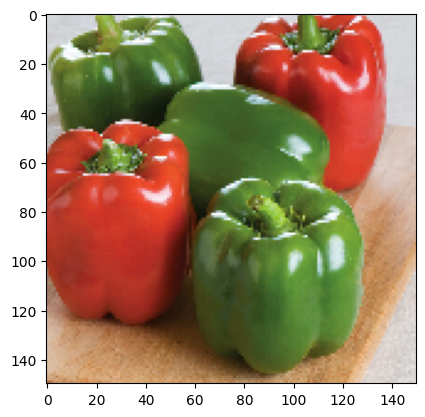

In [67]:
plt.imshow(img)

In [68]:
# Get class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

#print("Class Indices:", class_indices)
print("Class Names:", class_names)

Class Names: {0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot', 7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger', 14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce', 19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple', 26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn', 32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}


In [69]:
class_names

{0: 'apple',
 1: 'banana',
 2: 'beetroot',
 3: 'bell pepper',
 4: 'cabbage',
 5: 'capsicum',
 6: 'carrot',
 7: 'cauliflower',
 8: 'chilli pepper',
 9: 'corn',
 10: 'cucumber',
 11: 'eggplant',
 12: 'garlic',
 13: 'ginger',
 14: 'grapes',
 15: 'jalepeno',
 16: 'kiwi',
 17: 'lemon',
 18: 'lettuce',
 19: 'mango',
 20: 'onion',
 21: 'orange',
 22: 'paprika',
 23: 'pear',
 24: 'peas',
 25: 'pineapple',
 26: 'pomegranate',
 27: 'potato',
 28: 'raddish',
 29: 'soy beans',
 30: 'spinach',
 31: 'sweetcorn',
 32: 'sweetpotato',
 33: 'tomato',
 34: 'turnip',
 35: 'watermelon'}

In [70]:
#singe prediction
print("it's a {}".format(class_names[result_index[0][0]]))

it's a bell pepper


In [36]:
model.evaluate(val_generator)

11/11 [==============================] - 15s 1s/step - loss: 1.0951 - accuracy: 0.9687 - precision: 0.9769 - mae: 0.0022


[1.095053791999817,
 0.9686609506607056,
 0.9769452214241028,
 0.0022026628721505404]

In [37]:
model.evaluate(train_generator)

98/98 [==============================] - 107s 1s/step - loss: 0.9717 - accuracy: 0.9936 - precision: 0.9936 - mae: 5.2843e-04


[0.971712589263916,
 0.9935794472694397,
 0.9935794472694397,
 0.0005284275393933058]

In [38]:
model.evaluate(test_generator)

12/12 [==============================] - 15s 1s/step - loss: 1.1163 - accuracy: 0.9666 - precision: 0.9745 - mae: 0.0028


[1.1162784099578857,
 0.9665738344192505,
 0.9745042324066162,
 0.002834606682881713]

In [49]:
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Print class names
print("Class Names:", class_names)

# Save the class names to a file
with open("label.txt", "w") as file:
    for index, label in class_names.items():
        file.write(f"{index}: {label}\n") 

Class Names: {0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot', 7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger', 14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce', 19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple', 26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn', 32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}
